# Tutorial 6: Gaussian Process Model with Multi-fidelity Learning

In this notebook, we will train a multi-fidelity Gaussian Process (GP) model. This type of model can aggregate training data with different fidelities, therefore optimizing the trade-off between training cost and accuracy. A major motive behind employing multi-fidelity strategies lies in its premise of using the low-fidelity model for quick explorations of the parameter space, while keeping the high-fidelity model in the loop to ensure accuracy

For a theoretical introduction of this learning scheme, please see: [S. Guo, C. F. Silva, W. Polifke, Robust identification of flame frequency response via multi-fidelity Gaussian process approach, 2021, *Journal of Sound and Vibration*, 502, pp. 116083.](https://www.sciencedirect.com/science/article/abs/pii/S0022460X21001553). 

If you have further questions, please contact Shuai Guo at guo@tfd.mw.tum.de

In [1]:
# Set module path
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\GaussianProcess")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyDOE import lhs

# Import GP interpolation module
from GPInterpolator import GPInterpolator

%matplotlib inline

## 1. Test Function

In this tutorial, we try to approximate the following function, which we assume is a high-fidelity function:

\begin{equation}
y(x) = (6x-2)^2sin(12x-4), \; x \in [0, 1]
\end{equation}

In addition to the training data directly generated from the above function, we also have some training data generated from a low-fidelity approximation of the above function: 

\begin{equation}
y(x) = 0.5(6x-2)^2sin(12x-4)+10(x-0.5)-5, \; x \in [0, 1]
\end{equation}

Later on, we will train a multi-fidelity GP model to aggregate training data from both fidelities and the resulting GP model can accurately approximate the high-fidelity function. 

In [13]:
def HF_function(x):
    y = (6*x-2)**2*np.sin(12*x-4)
    return y

def LF_function(x):
    y = 0.5*(6*x-2)**2*np.sin(12*x-4) + 10*(x-0.5) - 5
    return y

## 2. Generating training/testing dataset

For the current multi-fidelity modeling task, we sample the design space extensively using the low-fidelity function, but only run the high-fidelity function at several of these points.

In [14]:
# Low-fidelity training dataset
X_train_LF = np.linspace(0, 1, 11).reshape(-1,1)
y_train_LF = LF_function(X_train_LF)

# High-fidelity training dataset
X_train_HF = np.array([0, 0.4, 0.6, 1]).reshape(-1,1)
y_train_HF = HF_function(X_train_HF)

# Test data
X_test = np.linspace(0, 1, 100).reshape(-1,1)
y_test = HF_function(X_test)

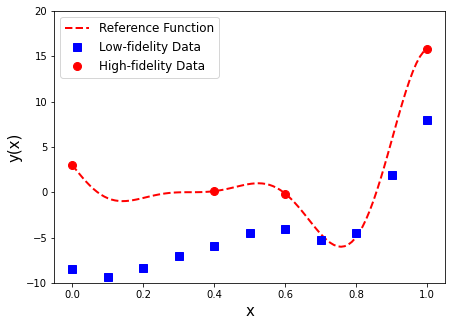

In [23]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test,'r--', lw=2, label='Reference Function')
ax.plot(X_train_LF, y_train_LF, 'bs', markerfacecolor='b', 
        markersize=8, label='Low-fidelity Data')
ax.plot(X_train_HF, y_train_HF, 'ro', markerfacecolor='r', 
        markersize=8, label='High-fidelity Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left",prop={'size': 12});

As we can see from the above figure, the low-fidelity data only qualitatively captures the trend of the reference function. In the following, we will see that by augmenting a few high-fidelity training data with extensive low-fidelity data, we are able to approximate the reference function accurately.

### 3. Multi-fidelity GP model

In [24]:
multi_GP = GPInterpolator(trend=y_train_LF)

In [26]:
multi_GP.__dict__

{'verbose': False,
 'n_restarts': 20,
 'opt': {'optimizer': 'L-BFGS-B', 'jac': True},
 'init_point': None,
 'kernel': 'Gaussian',
 'trend': array([[-8.48639501],
        [-9.32828839],
        [-8.31986355],
        [-7.00778837],
        [-5.94261151],
        [-4.54535129],
        [-4.0747189 ],
        [-5.30287702],
        [-4.47456522],
        [ 1.85597517],
        [ 7.91486597]]),
 'nugget': 1e-10}

In [27]:
multi_GP.fit(X_train_HF, y_train_HF)

D:\Published_papers\GaussianProcess\GaussianProcess\GPInterpolator.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.trend == 'Const':
D:\Published_papers\GaussianProcess\GaussianProcess\GPInterpolator.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.trend == 'Linear':
D:\Published_papers\GaussianProcess\GaussianProcess\GPInterpolator.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif self.trend == 'Quadratic':


ValueError: incompatible dimensions.

In [28]:
multi_GP.F

AttributeError: 'GPInterpolator' object has no attribute 'F'

In [31]:
multi_GP.trend = 'Const'

In [32]:
isinstance(multi_GP.trend, str)

True